### Competition Description
The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. The train/test split has been preserved for the purposes of benchmarking, but the sentences have been shuffled from their original order. Each Sentence has been parsed into many phrases by the Stanford parser. Each phrase has a PhraseId. Each sentence has a SentenceId. Phrases that are repeated (such as short/common words) are only included once in the data.
0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)
import numpy as np
import scipy as sp

import warnings
warnings.filterwarnings('ignore')

# Plotting packs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLP packs
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from stop_words import get_stop_words
from textblob import TextBlob , Word
import re 
import string

##Wordcloud Modules
from wordcloud import WordCloud , STOPWORDS

#Machine learning Packs
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier 
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

In [2]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abagci.NTS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
train = pd.read_table('train.tsv')
test = pd.read_table('test.tsv')

## EDA
### Data exploration
Examining the dataset to understand its structure, size, and the types of variables it contains.

In [4]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [5]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [6]:
df= train.append(test)

### Data Preparation

In [7]:
df['Phrase']=df['Phrase'].str.lower().str.replace('[^\w\s]','').str.replace('\d+','').str.replace('\n',' ').replace('\r','').str.replace("[^a-zA-Z0-9\s]",'') 

In [8]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer_output = WordNetLemmatizer()

df['Phrase'] = df['Phrase'].apply(lambda x : word_tokenize(x.lower())) # lowercase 
df["Phrase"] = df["Phrase"].apply(lambda x : [word for word in x if word not in STOPWORDS]) # remove stop words
df["Phrase"] = df["Phrase"].apply(lambda x : [lemmatizer_output.lemmatize(word) for word in x]) # get roots of the words
df["Phrase"] = df["Phrase"].apply(lambda x : " ".join(x))

### Word Cloud

In [9]:
def wc(data,bgcolor): # word cloud
    plt.figure(figsize=(10,10))
    wc=WordCloud(background_color=bgcolor,max_words=100, min_word_length=4, contour_width=3, contour_color='steelblue')
    wc.generate(" ".join(data))
    plt.imshow(wc)
    plt.axis("off")

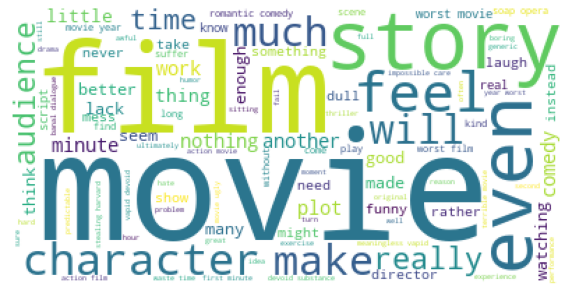

In [10]:
wc(df[df.Sentiment==0.0].Phrase, 'white') # negativ

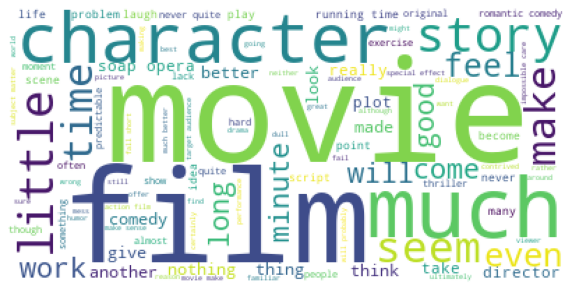

In [11]:
wc(df[df.Sentiment==1.0].Phrase, 'white') # somewhat negative

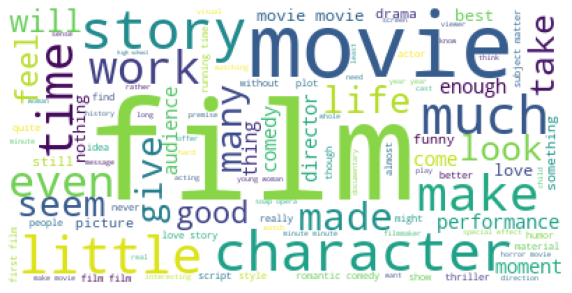

In [12]:
wc(df[df.Sentiment==2.0].Phrase, 'white') # neutral

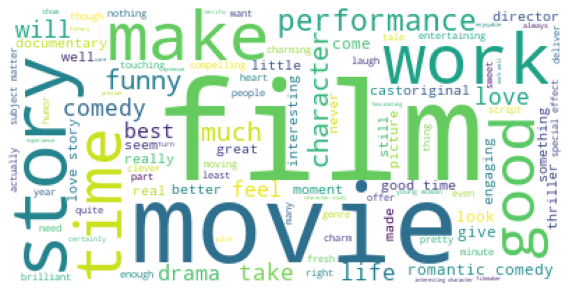

In [13]:
wc(df[df.Sentiment==3.0].Phrase, 'white') # somewhat positiv

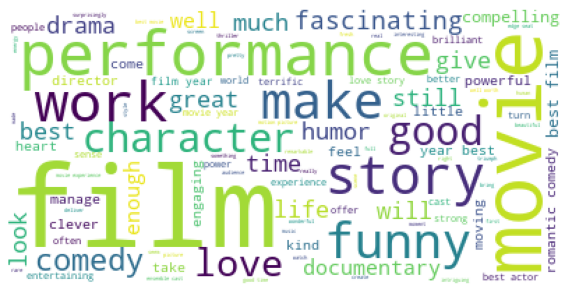

In [14]:
wc(df[df.Sentiment==4.0].Phrase, 'white') # positiv

### Data Cleaning

In [15]:
def word_cleaner(data):
    words=[re.sub("[^a-zA-Z]"," ",i)for i in data] # noktalamalı kaldır
    words=[i.lower()for j in words for i in j.split()]#Splitting all the sentences into words
    words=[i for i in words if not i in set(stopwords.words("english"))]#removing stopwords
    #words=[i for i in words if len(i)>2 ]#2 den büyük kelimeleri al # bu ozellik wordcloud da zaten var aslinda
    return words

### Data Modeling 
Creating models to make predictions or classify the data.

In [16]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences  

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df['Phrase'].values)
sequences = tokenizer.texts_to_sequences(df['Phrase'].values)
df_dtm=pad_sequences(sequences, maxlen=200)

df_train_dtm = df_dtm[:train.shape[0]]
df_test_dtm = df_dtm[train.shape[0]:]

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dense, Flatten, Dropout, LSTM, Embedding, Bidirectional, BatchNormalization

model=Sequential()
model.add(Embedding(20000, 500, input_length=df_train_dtm.shape[1])),
model.add(Bidirectional(LSTM(64,  activation='relu'))),

model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(5, activation='softmax'))
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 500)          10000000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              289280    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16)                0

In [18]:
from tensorflow.keras.utils import to_categorical
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(df_train_dtm, to_categorical(train.Sentiment.values), validation_split=0.20, epochs=5, batch_size=289, verbose=1)

Epoch 1/5
432/432 [==============================] - 1179s 3s/step - loss: 1.3091 - accuracy: 0.5131 - val_loss: 1.0989 - val_accuracy: 0.5534
Epoch 2/5
432/432 [==============================] - 1377s 3s/step - loss: 0.9334 - accuracy: 0.6349 - val_loss: 1.0883 - val_accuracy: 0.5838
Epoch 3/5
432/432 [==============================] - 1176s 3s/step - loss: 0.8400 - accuracy: 0.6646 - val_loss: 1.3595 - val_accuracy: 0.5064
Epoch 4/5
432/432 [==============================] - 1179s 3s/step - loss: 0.7808 - accuracy: 0.6839 - val_loss: 1.1337 - val_accuracy: 0.5861
Epoch 5/5
432/432 [==============================] - 1188s 3s/step - loss: 0.7380 - accuracy: 0.6979 - val_loss: 1.1122 - val_accuracy: 0.5767


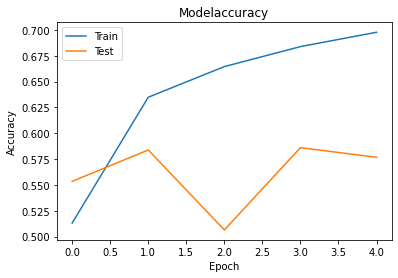

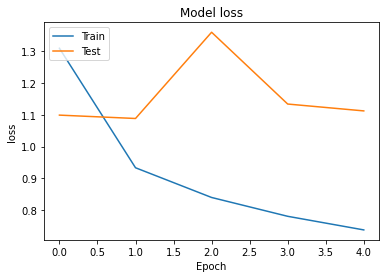

In [19]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Modelaccuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("Epoch")
plt.legend(["Train","Test"],loc="upper left")
plt.show()